In [1]:
%matplotlib inline

In [2]:
!gdown 1FXCLAdHuxLC6vdomqD37j5CvUgrMiKn_

Downloading...
From: https://drive.google.com/uc?id=1FXCLAdHuxLC6vdomqD37j5CvUgrMiKn_
To: /content/RoadSigns.zip
100% 38.7M/38.7M [00:00<00:00, 271MB/s]


In [3]:
!unzip RoadSigns.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
 extracting: RoadSigns/train/1.23/017139.png  
 extracting: RoadSigns/train/1.23/017140.png  
 extracting: RoadSigns/train/1.23/017141.png  
 extracting: RoadSigns/train/1.23/017142.png  
  inflating: RoadSigns/train/1.23/017143.png  
 extracting: RoadSigns/train/1.23/017144.png  
 extracting: RoadSigns/train/1.23/017145.png  
 extracting: RoadSigns/train/1.23/017146.png  
 extracting: RoadSigns/train/1.23/017147.png  
 extracting: RoadSigns/train/1.23/017148.png  
 extracting: RoadSigns/train/1.23/018217.png  
 extracting: RoadSigns/train/1.23/018218.png  
 extracting: RoadSigns/train/1.23/018219.png  
 extracting: RoadSigns/train/1.23/018220.png  
 extracting: RoadSigns/train/1.23/018221.png  
 extracting: RoadSigns/train/1.23/018222.png  
 extracting: RoadSigns/train/1.23/018223.png  
 extracting: RoadSigns/train/1.23/018224.png  
 extracting: RoadSigns/train/1.23/018225.png  
 extracting: RoadSigns/train/1.23/01822

In [4]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [5]:
#train and test data directory
train_data_dir = "./RoadSigns/train"
test_data_dir = "./RoadSigns/test"

size = 32

#load the train and test data
train_dataset = ImageFolder(train_data_dir, transform=transforms.Compose([
    transforms.Resize((size, size)), 
    transforms.ToTensor()
]))
test_dataset = ImageFolder(test_data_dir, transform=transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor()
]))

In [6]:
classes = train_dataset.classes
print("Знаки дорожного движения по номерам: \n", classes)

Знаки дорожного движения по номерам: 
 ['1.1', '1.11.1', '1.11.2', '1.12.2', '1.15', '1.16', '1.17', '1.20.1', '1.20.2', '1.20.3', '1.22', '1.23', '1.25', '1.5', '2.1', '2.3.2', '2.3.3', '2.4', '2.5', '3.1', '3.13', '3.18.1', '3.18.2', '3.19', '3.2', '3.24.10', '3.24.110', '3.24.20', '3.24.30', '3.24.40', '3.24.5', '3.24.50', '3.24.60', '3.24.80', '3.24.90', '3.27', '3.28', '3.29', '3.30', '3.4', '4.1.1', '4.1.2', '4.1.4', '4.1.5', '4.2.1', '4.2.2', '4.2.3', '4.3', '5.19']


In [7]:
img, _ = train_dataset[0]
print(len(train_dataset.classes), len(train_dataset), len(test_dataset), img.shape)

49 6173 1453 torch.Size([3, 32, 32])


Номер в базе: 1.1


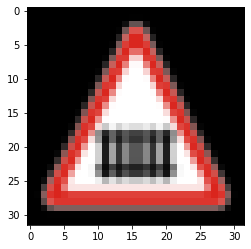

In [8]:
import matplotlib.pyplot as plt

def show_image(img, label):
    print(f"Номер в базе: {train_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

show_image(*train_dataset[0])

In [9]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 128
val_split = 0.1 # процент данных для валидации
val_size = (int)(val_split * len(train_dataset))
train_size = len(train_dataset) - val_size

train_data, val_data = random_split(train_dataset, [train_size, val_size])
print(f"Количество тренировочных данных: {len(train_data)}")
print(f"Количество данных для проверки: {len(val_data)}")

# загрузка данных в батчи
train_data_loader = DataLoader(train_data, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_data_loader = DataLoader(val_data, batch_size*2, num_workers = 2, pin_memory = True)

Количество тренировочных данных: 5556
Количество данных для проверки: 617


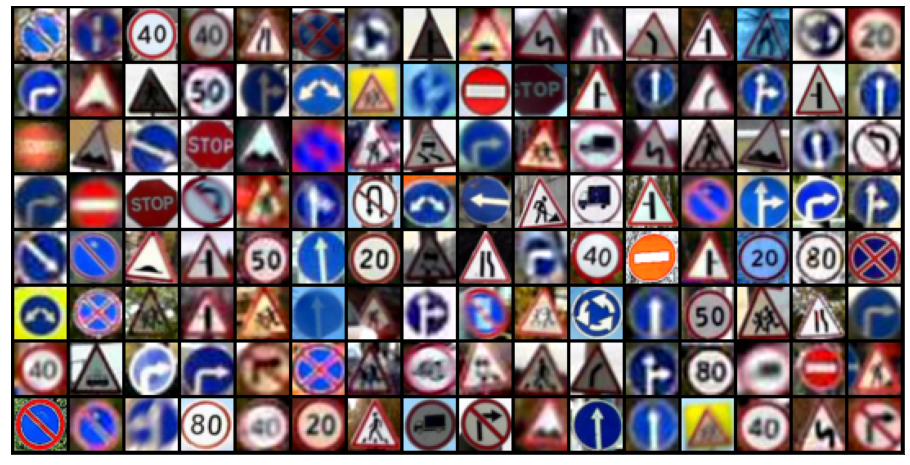

In [10]:
from torchvision.utils import make_grid

def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_data_loader)

In [11]:
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():
  device = torch.device("cuda") # для выполнения обучения на gpu и его ускорения
else:
  device = torch.device("cpu")

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)
        out = self(images)                  # генерация прогнозов
        loss = F.cross_entropy(out, labels) # вычисление ошибки
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)
        out = self(images)                    # генерация пронозов
        loss = F.cross_entropy(out, labels)   # вычисление ошибки
        acc = accuracy(out, labels)           # расчет точности 
        # точность = количество правильных прогнозов/общее количество прогнозов
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # объединение ошибок
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # объединение точностей
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Эпоха {}:\nобучающая ошибка: {:.3f}, проверочная ошибка: {:.3f}, точность: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [12]:
class ClassificationModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=5, padding=2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(2*size*size, 256),
            nn.ReLU(),
            nn.Linear(256, len(classes))
        )
    
    def forward(self, xb):
        return self.network(xb)

In [13]:
model = ClassificationModel()
model = model.to(device)

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [15]:
num_epochs = 6 # количество эпох
opt_func = torch.optim.Adam
lr = 0.001
# обучение модели и вывод результатов обучения после каждой эпохи
history = fit(num_epochs, lr, model, train_data_loader, val_data_loader, opt_func)

Эпоха 0:
обучающая ошибка: 1.048, проверочная ошибка: 0.370, точность: 0.8828
Эпоха 1:
обучающая ошибка: 0.118, проверочная ошибка: 0.092, точность: 0.9702
Эпоха 2:
обучающая ошибка: 0.027, проверочная ошибка: 0.032, точность: 0.9935
Эпоха 3:
обучающая ошибка: 0.011, проверочная ошибка: 0.034, точность: 0.9883
Эпоха 4:
обучающая ошибка: 0.007, проверочная ошибка: 0.032, точность: 0.9929
Эпоха 5:
обучающая ошибка: 0.009, проверочная ошибка: 0.028, точность: 0.9890


In [16]:
from torchsummary import summary

summary(model.cuda(), (3, size, size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,400
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          51,200
              ReLU-6           [-1, 64, 16, 16]               0
       BatchNorm2d-7           [-1, 64, 16, 16]             128
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]         204,800
             ReLU-10            [-1, 128, 8, 8]               0
      BatchNorm2d-11            [-1, 128, 8, 8]             256
        MaxPool2d-12            [-1, 128, 4, 4]               0
          Flatten-13                 [-1, 2048]               0
           Linear-14                  [

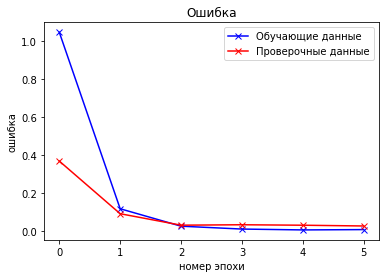

In [17]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('номер эпохи')
    plt.ylabel('ошибка')
    plt.legend(['Обучающие данные', 'Проверочные данные'])
    plt.title('Ошибка');

plot_losses(history)

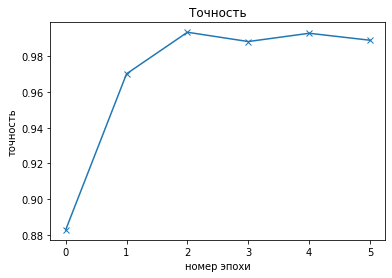

In [18]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('номер эпохи')
    plt.ylabel('точность')
    plt.title('Точность');

plot_accuracies(history)

In [19]:
# Сохранение в формате PyTorch Mobile
model = model.cpu()
dummy_input = torch.rand(1, 3, size, size)
torchscript_model = torch.jit.trace(model, dummy_input)

from torch.utils.mobile_optimizer import optimize_for_mobile
torchscript_model_optimized = optimize_for_mobile(torchscript_model)
torchscript_model_optimized.save("TSR_model.pt")

In [20]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

network.0.weight tensor([[[[-1.2382e-01,  3.7557e-02,  5.2759e-02,  1.2021e-01, -6.8235e-02],
          [-4.1506e-02,  1.6258e-02, -9.8741e-02,  1.4414e-02,  6.7218e-02],
          [ 1.7479e-02, -5.4523e-02,  8.3995e-02,  1.0414e-01, -4.0559e-02],
          [ 5.1395e-02, -8.5386e-02, -9.2880e-02,  8.8052e-02, -1.1344e-01],
          [ 2.0172e-03, -2.5025e-02, -4.1265e-02, -8.4918e-02,  7.6635e-02]],

         [[-5.7121e-02, -1.0357e-01, -2.0714e-02,  3.6698e-02,  1.0729e-01],
          [-1.0330e-01,  9.9015e-02, -2.5693e-02, -4.1475e-02,  5.9641e-02],
          [ 4.4371e-02,  2.8055e-02,  7.3064e-02,  1.2530e-01, -3.5987e-02],
          [ 5.4208e-03, -9.3493e-03,  7.0054e-02,  6.9368e-02, -6.2541e-03],
          [-7.7714e-02,  5.0900e-02, -2.7297e-02, -6.6789e-02,  5.3646e-02]],

         [[-6.8817e-02, -1.3709e-01,  5.9995e-02, -7.9552e-03,  6.3543e-02],
          [ 4.5080e-02,  8.0348e-02,  4.5967e-02,  3.0555e-03,  6.2188e-02],
          [-6.4941e-02, -8.5146e-02,  7.5819e-03,  7.69

In [21]:
model = model.cuda()
test_loader = DataLoader(test_dataset, batch_size*2, device)
result = evaluate(model, test_loader)
print(result)

{'val_loss': 0.3139558434486389, 'val_acc': 0.9272150993347168}


In [22]:
def to_device(data, device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking = True)

In [23]:
def predict_img_class(img, model):
    img = to_device(img.unsqueeze(0), device)
    prediction =  model(img)
    _, preds = torch.max(prediction, dim = 1)
    return train_dataset.classes[preds[0].item()]

Прогнозируемый класс: 1.23


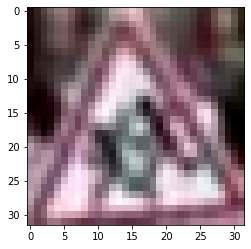

In [24]:
from PIL import Image

model = model.cuda()
# открытие изображения
img = Image.open("./RoadSigns/test/1.23/000426.png")
# перевод изоражения в тензоры
img = transforms.Compose([transforms.Resize((size, size)), transforms.ToTensor()])(img)
# вывод изображения
plt.imshow(img.permute(1,2,0))
# прогнозирование класса
print(f"Прогнозируемый класс: {predict_img_class(img, model)}")

Прогнозируемый класс: 2.1


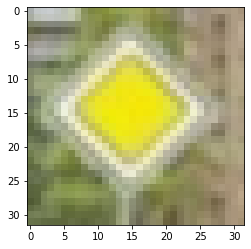

In [25]:
img2 = Image.open("./RoadSigns/test/2.1/00.jpg")
img2 = transforms.Compose([transforms.Resize((size, size)), transforms.ToTensor()])(img2)
plt.imshow(img2.permute(1,2,0))
print(f"Прогнозируемый класс: {predict_img_class(img2, model)}")

In [26]:
print(model)

ClassificationModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=2048, out_features=256, bias=True)
    (14): ReLU()

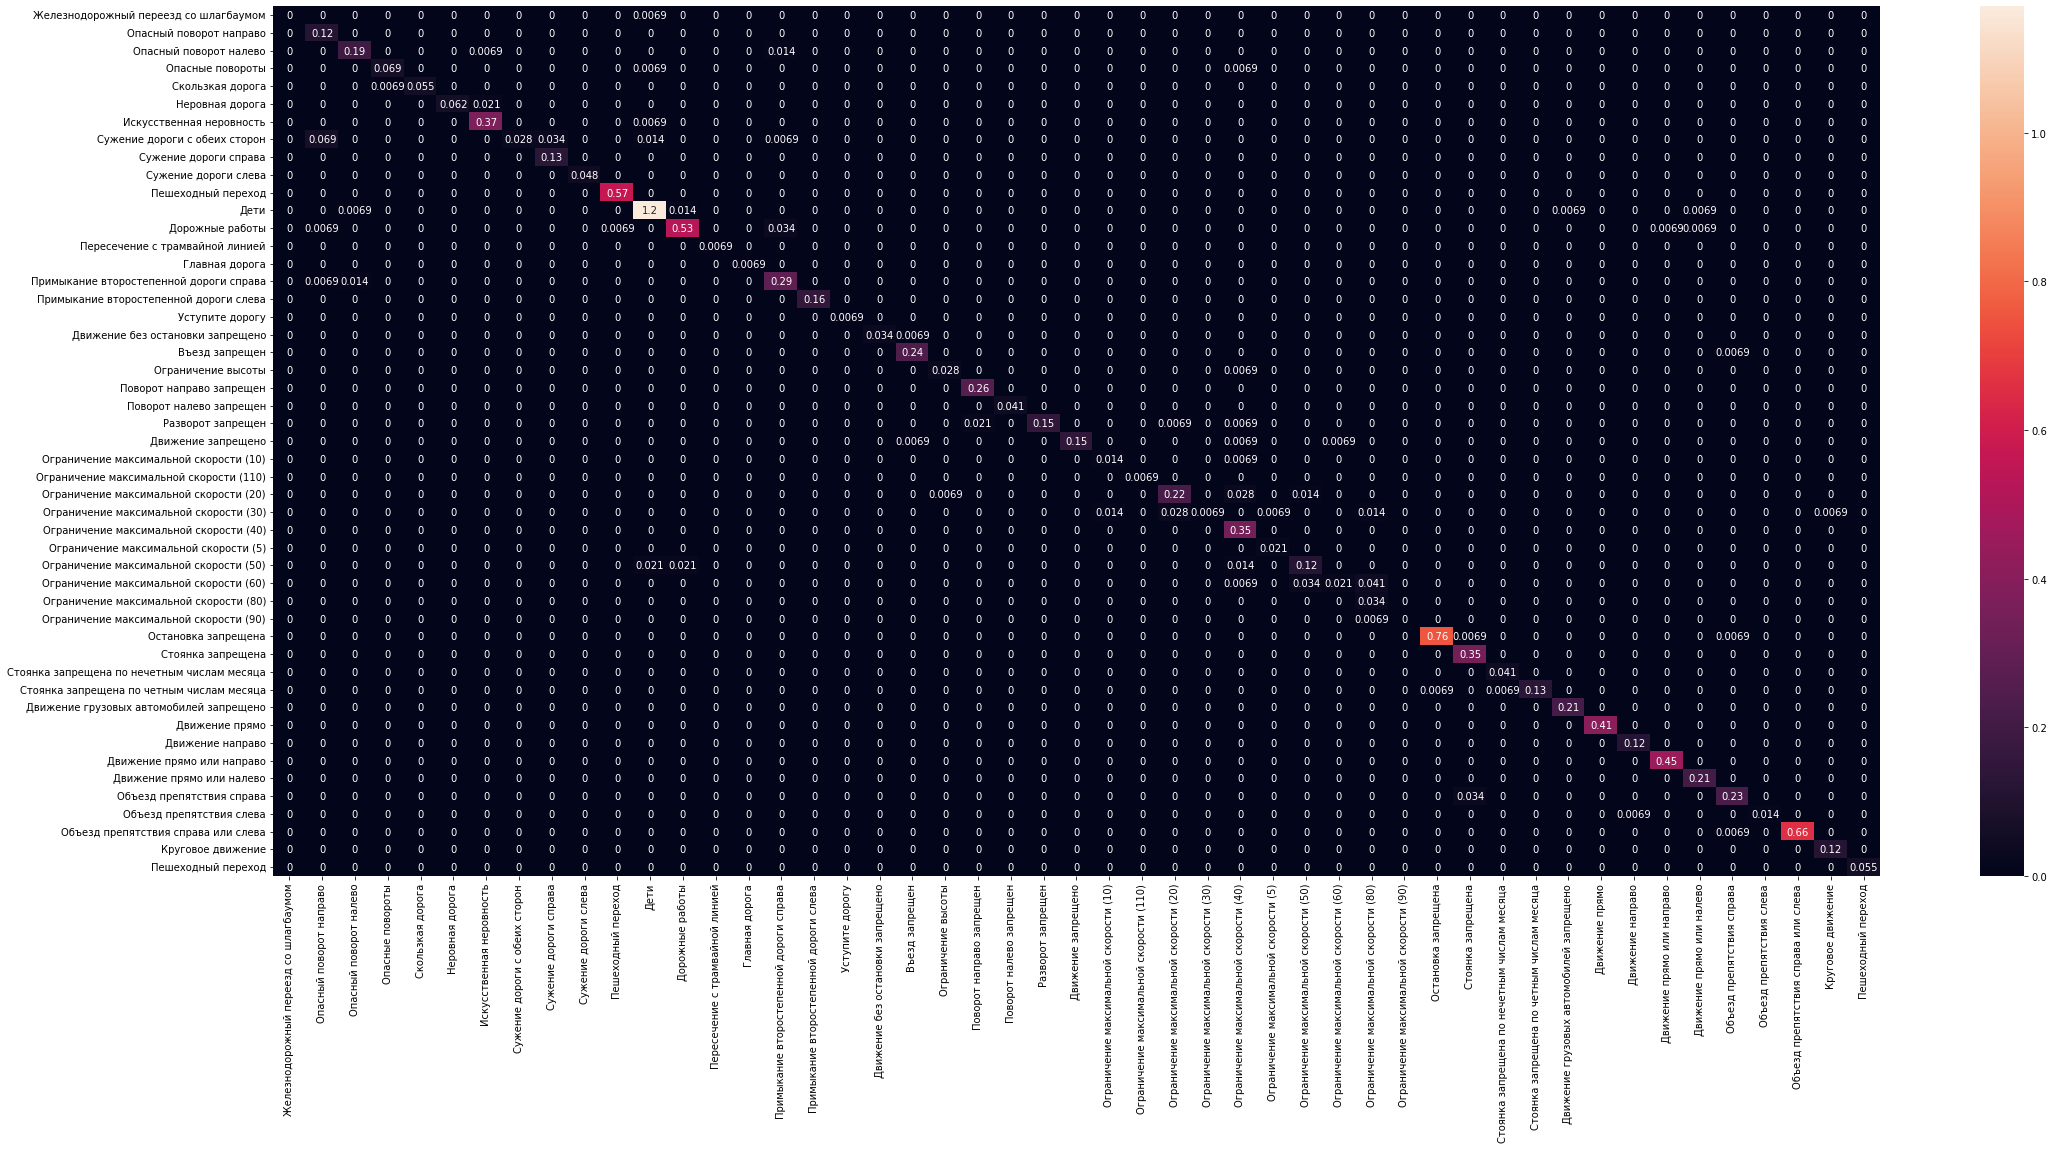

In [27]:
# построение матрицы путаницы
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

y_pred = []
y_true = []
model = model.cpu()

for inputs, labels in test_loader:
        output = model(inputs)
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

classes = ("Железнодорожный переезд со шлагбаумом",
          "Опасный поворот направо",
          "Опасный поворот налево",
          "Опасные повороты",
          "Скользкая дорога",
          "Неровная дорога",
          "Искусственная неровность",
          "Сужение дороги с обеих сторон",
          "Сужение дороги справа",
          "Сужение дороги слева",
          "Пешеходный переход",
          "Дети",
          "Дорожные работы",
          "Пересечение с трамвайной линией",
          "Главная дорога",
          "Примыкание второстепенной дороги справа",
          "Примыкание второстепенной дороги слева",
          "Уступите дорогу",
          "Движение без остановки запрещено",
          "Въезд запрещен",
          "Ограничение высоты",
          "Поворот направо запрещен",
          "Поворот налево запрещен",
          "Разворот запрещен",
          "Движение запрещено",
          "Ограничение максимальной скорости (10)",
          "Ограничение максимальной скорости (110)",
          "Ограничение максимальной скорости (20)",
          "Ограничение максимальной скорости (30)",
          "Ограничение максимальной скорости (40)",
          "Ограничение максимальной скорости (5)",
          "Ограничение максимальной скорости (50)",
          "Ограничение максимальной скорости (60)",
          "Ограничение максимальной скорости (80)",
          "Ограничение максимальной скорости (90)",
          "Остановка запрещена",
          "Стоянка запрещена",
          "Стоянка запрещена по нечетным числам месяца",
          "Стоянка запрещена по четным числам месяца",
          "Движение грузовых автомобилей запрещено",
          "Движение прямо",
          "Движение направо",
          "Движение прямо или направо",
          "Движение прямо или налево",
          "Объезд препятствия справа",
          "Объезд препятствия слева",
          "Объезд препятствия справа или слева",
          "Круговое движение",
          "Пешеходный переход")

confusion_matrix = confusion_matrix(y_true, y_pred)
dataframe = pd.DataFrame(confusion_matrix / np.sum(confusion_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (36,16))
sn.heatmap(dataframe, annot=True)
plt.savefig('confusion_matrix.png')